In [19]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import time
from reservoir import Reservoir
import data_utils

%load_ext autoreload
%autoreload 2
%aimport reservoir
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import pickle

# TODO: check if no boundery changes performance

def load_input(path, sequence_length=None, n_repeat=1, derivative_order=0, normalize=True):
    T = np.load(path)[1:-1, :, :] # skipping the boundary layers
    
    if sequence_length is not None:
        T_interp = np.zeros((T.shape[0], T.shape[1], sequence_length))
        sequence = np.arange(T.shape[2])
        sequence_new = np.linspace(0, T.shape[2], sequence_length)
        for xi in range(T.shape[0]):
            for yi in range(T.shape[1]):
                T_interp[xi, yi, :] = np.interp(sequence_new, sequence, T[xi, yi, :])
        T = T_interp
        
    if derivative_order==2:
        for i in range(derivative_order):
                T = np.gradient(T, axis= (0, 1))
        T = T[0][0] + T[-1][-1] # get rid of mixed derivatives
    if normalize:
        x_dim, y_dim, sequence_length = T.shape
        T = np.transpose(T.reshape((x_dim*y_dim, sequence_length))).reshape((1, sequence_length, x_dim*y_dim))
    if n_repeat>1:
        T = np.tile(T, (n_repeat, 1, 1))
    return T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fitting the algorithm

In [34]:
target_data.shape

(4, 500, 2424)

In [24]:
n_repeat = 1
sequence_length = 500
num_datasets =  4
x_dim = 101
y_dim = 24
raw_train_data = np.zeros((num_datasets, y_dim, x_dim, sequence_length))
train_data = np.zeros((num_datasets*n_repeat, sequence_length, y_dim*x_dim))
target_data = np.zeros((num_datasets*n_repeat, sequence_length, y_dim*x_dim))


for i in range(num_datasets):
    path = "2D_convection_datasets/x_y_temperature_deltaT_" + str(2*(i+1)) + ".npy"
    
    raw_train_data[i*n_repeat:(i+1)*n_repeat, :, :] = load_input(
        path, sequence_length=sequence_length, n_repeat = 1, derivative_order=0, normalize=False)
    
    train_data[i*n_repeat:(i+1)*n_repeat, :, :] = load_input(
        path, sequence_length=sequence_length, n_repeat = n_repeat, derivative_order=2, normalize=True)
    
    target_data[i*n_repeat:(i+1)*n_repeat, :, :] = load_input(
        path, sequence_length=sequence_length, n_repeat = n_repeat, derivative_order=0, normalize=True)

    

n_sequence, sequence_length, spatial_points = train_data.shape
b = Reservoir(n_res=5000, res_scale=1, res_encoding='phase', res_enc_param=1.*np.pi,
              input_scale=1, input_encoding='phase', input_enc_param = 1.*np.pi,
              random_projection='simulation', weights_type='complex gaussian',
              activation_fun='intensity', activation_param=1,
              parallel_runs=n_sequence,  bias_scale=0.2, leak_rate=0.3,
              pred_horizon=100, rec_pred_steps=1, forget = 50,
              train_method='ridge', train_param=1e0, verbose=1
             )

# Algorithm training
b.fit(train_data);

# Testing the data

In [13]:
raw_test_data = load_input("2D_convection_datasets/x_y_temperature_deltaT_10.npy", 
                           sequence_length=5000, n_repeat = 1, derivative_order=0, normalize=False)
test_data = load_input("2D_convection_datasets/x_y_temperature_deltaT_10.npy", 
                       sequence_length=5000, n_repeat = 1, derivative_order=2,normalize=True)
n_sequence, sequence_length, spatial_points = test_data.shape

# Algorithm testing
b.parallel_runs = n_sequence
pred_output, valid_score = b.predict_and_score(test_data, detailed_score=True)

Reservoir Computing algorithm - Testing phase:

Initialization complete. 		Elapsed time: 0.8516993522644043 s
100%|██████████| 5000/5000 [01:30<00:00, 54.99it/s]
Reservoir iterations complete. 		Elapsed time: 91.07704043388367 s
Testing complete. 			Elapsed time: 5090.006200313568 s
Testing score: 0.6034681964450764


In [ ]:
# dump information/read dumped information
# file = open('reservoir_dumped', 'wb')
# pickle.dump(b, file, protocol=4)
# file.close()
# file = open('reservoir_dumped', 'rb')
# b = pickle.load(file)
# file = open('reservoir_dumped', 'rb')

np.save('prediction_n_res_5000_n_pred_100_dT_10', pred_output)
# b.output_w = np.load('dumped_output_weights/output_weights_n_res_10000_n_pred_5.npy')

# one-step prediction at different times

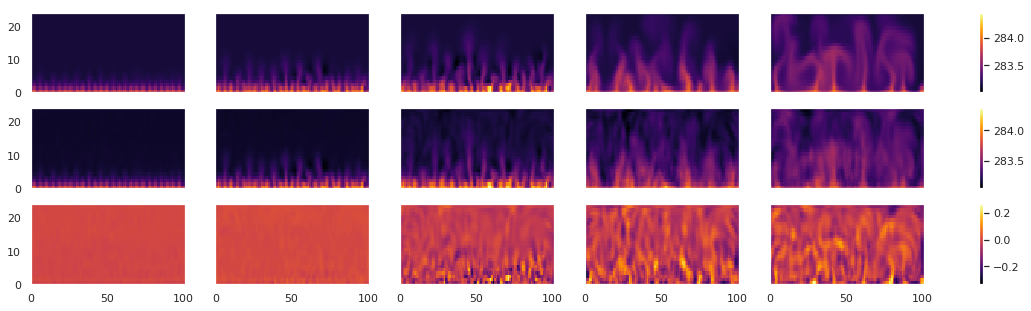

In [230]:
# # modifying back the datasets into their initial form
# T_max = np.amax(raw_test_data)
# T_min = np.amin(raw_test_data)
# x_dim, y_dim, sequence_length = raw_test_data.shape
# pred_output_ = pred_output.reshape(
#     sequence_length-b.forget, b.pred_horizon, x_dim, y_dim)*((T_max - T_min)/2) + (T_max + T_min)/2
# test_data_ = test_data[0, b.forget:].reshape(
#     sequence_length-b.forget, x_dim, y_dim)*((T_max - T_min)/2) + (T_max + T_min)/2

times = [415, 2*415, 3*415, 4*415, 5*415]
T_test_max = np.amax([test_data_[j+1, :, :] for j in times])
T_test_min = np.amin([test_data_[j+1, :, :] for j in times])
T_pred_max = np.amax([pred_output_[j, 0, :, :] for j in times])
T_pred_min = np.amin([pred_output_[j, 0, :, :] for j in times])
T_diff_max = np.amax([test_data_[j+1, :, :] - pred_output_[j, 0, :, :] for j in times])
T_diff_min = np.amin([test_data_[j+1, :, :] - pred_output_[j, 0, :, :] for j in times])

n_fig = 5
fig, axs = plt.subplots(3, n_fig, sharey=True, sharex=True, figsize=(20,5))

for i in range(n_fig):
    t = times[i]
    im0 = axs[0, i].pcolormesh(test_data_[t+1, :, :], cmap='inferno', vmin=T_test_min, vmax=T_test_max)
#     plt.ylabel('x')
#     plt.xlabel('y')

    im1 = axs[1, i].pcolormesh(pred_output_[t, 0, :, :], cmap='inferno', vmin=T_pred_min, vmax=T_pred_max)
#     plt.ylabel('x')
#     plt.xlabel('y')
    
    im2 = axs[2, i].pcolormesh(
        test_data_[t+1, :, :] - pred_output_[t, 0, :, :], cmap='inferno', vmin=T_diff_min, vmax=T_diff_max)
#     plt.ylabel('x')
#     plt.xlabel('y')
        
fig.colorbar(im0, ax=axs[0, :].ravel().tolist(), shrink=1)
fig.colorbar(im1, ax=axs[1, :].ravel().tolist(), shrink=1)
fig.colorbar(im2, ax=axs[2, :].ravel().tolist(), shrink=1)
plt.show
plt.savefig('one-step_prediction_at_different_times.png', bbox_inches='tight', dpi=600)

# multi-step prediction starting from a given time moment

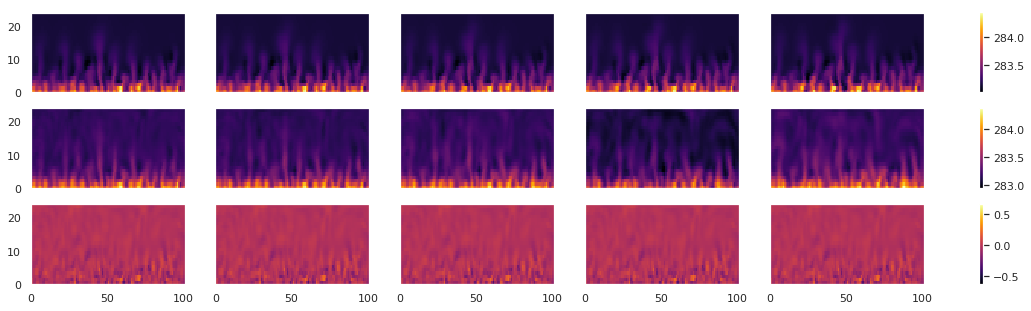

In [231]:
# modifying back the datasets into their initial form
# T_max = np.amax(raw_test_data)
# T_min = np.amin(raw_test_data)
# x_dim, y_dim, sequence_length = raw_test_data.shape
# pred_output_ = pred_output.reshape(
#     sequence_length-b.forget, b.pred_horizon, x_dim, y_dim)*((T_max - T_min)/2) + (T_max + T_min)/2
# test_data_ = test_data[0, b.forget:].reshape(
#     sequence_length-b.forget, x_dim, y_dim)*((T_max - T_min)/2) + (T_max + T_min)/2

t = 1250
pred_steps = [0, 25, 50, 75, 99]
T_test_max = np.amax([test_data_[t+k+1, :, :] for k in pred_steps])
T_test_min = np.amin([test_data_[t+k+1, :, :] for k in pred_steps])
T_pred_max = np.amax([pred_output_[t, k, :, :] for k in pred_steps])
T_pred_min = np.amin([pred_output_[t, k, :, :] for k in pred_steps])
T_diff_max = np.amax([test_data_[t+k+1, :, :] - pred_output_[t, k, :, :] for k in pred_steps])
T_diff_min = np.amin([test_data_[t+k+1, :, :] - pred_output_[t, k, :, :] for k in pred_steps])

n_fig = 5
fig, axs = plt.subplots(3, n_fig, sharey=True, sharex=True, figsize=(20,5))

for i in range(n_fig):
    
    j = pred_steps[i]
    im0 = axs[0, i].pcolormesh(test_data_[t+j+1, :, :], cmap='inferno', vmin=T_test_min, vmax=T_test_max)
#     plt.ylabel('x')
#     plt.xlabel('y')

    im1 = axs[1, i].pcolormesh(pred_output_[t, j, :, :], cmap='inferno', vmin=T_pred_min, vmax=T_pred_max)
#     plt.ylabel('x')
#     plt.xlabel('y')
    
    im2 = axs[2, i].pcolormesh(
        test_data_[t+1, :, :] - pred_output_[t, 0, :, :], cmap='inferno', vmin=T_diff_min, vmax=T_diff_max)
#     plt.ylabel('x')
#     plt.xlabel('y')
    
    
fig.colorbar(im0, ax=axs[0, :].ravel().tolist(), shrink=1)
fig.colorbar(im1, ax=axs[1, :].ravel().tolist(), shrink=1)
fig.colorbar(im2, ax=axs[2, :].ravel().tolist(), shrink=1)
plt.show
plt.savefig('multi-step_predictions_from_given_time.png', bbox_inches='tight', dpi=600)

# prediction RMSE

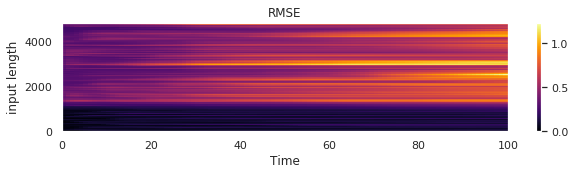

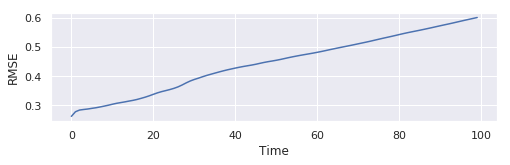

In [235]:
T_max = np.amax(raw_test_data)
T_min = np.amin(raw_test_data)
x_dim, y_dim, sequence_length = raw_test_data.shape
pred_output_ = pred_output.reshape(sequence_length-b.forget, b.pred_horizon, x_dim, y_dim)
true_data = test_data[0, b.forget:].reshape(sequence_length-b.forget, x_dim, y_dim)


total_pred = b.pred_horizon*b.rec_pred_steps
true_data_norm = true_data/np.std(true_data)
pred_output_norm = pred_output_/np.std(true_data)
length_input = pred_output_norm.shape[0] - total_pred
rmse = np.zeros((length_input, total_pred))
for n_input in range(1, length_input):
    for n_pred in range(1, total_pred+1):
        d1 = true_data_norm[n_input:n_input+n_pred, :, :]
        d2 = pred_output_norm[n_input-1, 0:n_pred, :]
        
        rmse[n_input-1, n_pred-1] = np.sqrt(1./(n_pred*spatial_points)*np.sum((d1.flatten() - d2.flatten())**2))

np.save('rmse_n_res_5000_n_pred_100_dT_10', rmse)

plt.figure(1,figsize=(10,2))
plt.title('RMSE')
plt.ylabel('input length')
plt.xlabel('Time')
im=plt.pcolormesh(rmse[:,:], cmap='inferno')
plt.colorbar(im)
plt.show;
plt.savefig('RMSE_map.png', bbox_inches='tight', dpi=600)

plt.figure(2,figsize=(8,2))
plt.ylabel('RMSE')
plt.xlabel('Time')
plt.plot(np.mean(rmse[:,:], axis=0))
plt.show;
plt.savefig('RMSE_averaged.png', bbox_inches='tight', dpi=600)

# multi-step prediction for a given y crossection

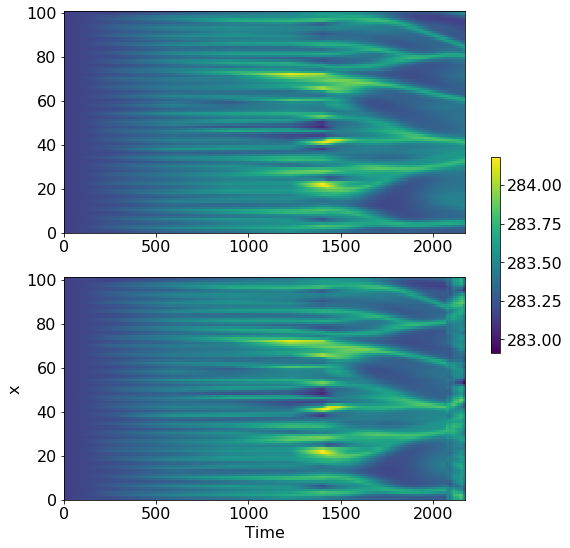

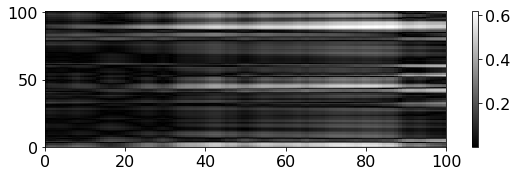

In [218]:
total_pred = b.pred_horizon*b.rec_pred_steps
n_input = 5*415 #round(pred_output.shape[0]/2-300)
y = 2
input_data = test_data_[:n_input, y, :]
prediction = pred_output_[n_input, :, y, :]
targetted_data = test_data_[n_input:n_input+total_pred, y, :]

vmax = np.amax(np.concatenate((targetted_data, input_data, prediction)))
vmin = np.amin(np.concatenate((targetted_data, input_data, prediction)))

# plot training data
fig, axs = plt.subplots(2, 1, sharex=False, figsize=(9,9))
plt.ylabel('x')
plt.xlabel('Time')
datum = [
    np.concatenate((input_data, targetted_data)), 
    np.concatenate((input_data, prediction)), 
    np.abs(targetted_data-prediction)]
for i in range(2):
    im=axs[i].pcolormesh(datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)
plt.savefig('prediction_target_2D.png')

plt.figure(3,figsize=(9,2.5))
im=plt.pcolormesh(datum[2].T, cmap='gray')
plt.colorbar(im)
plt.savefig('prediction_target_diff.png')

# multi-step prediction for a given y crossection

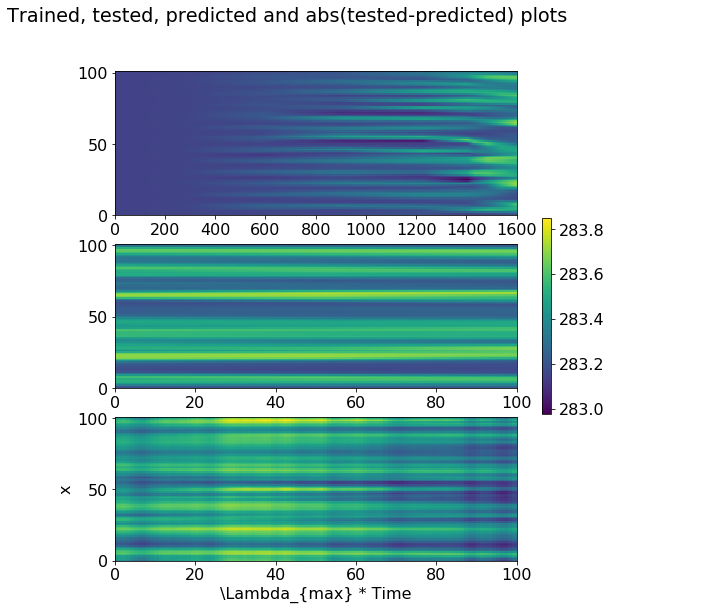

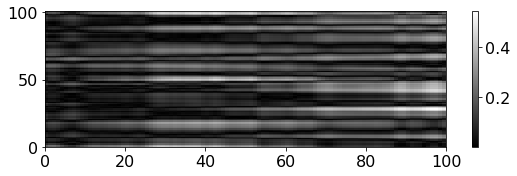

In [160]:
total_pred = b.pred_horizon*b.rec_pred_steps
n_input = 1600 #round(pred_output.shape[0]/2-300)
y = 5
input_data = test_data_[:n_input, y, :]
prediction = pred_output_[n_input, :, y, :]
targetted_data = test_data_[n_input:n_input+total_pred, y, :]

vmax = np.amax(abs(np.concatenate((targetted_data, input_data, prediction))))
vmin = np.min(abs(np.concatenate((targetted_data, input_data, prediction))))

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,9))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
for i in range(3):
    im=axs[i].pcolormesh(datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

plt.figure(3,figsize=(9,2.5))
im=plt.pcolormesh(datum[3].T, cmap='gray')
plt.colorbar(im)
# # plt.savefig('DND_input_data.png')